## SENTIMENT ANALYSIS USING BERT and 3-FOLD CROSS VALIDATION

In [1]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# 1. Load and Explore the Dataset

### Load the Data

1. Loading the data

In [2]:
df = pd.read_csv("IMDB Dataset.csv\IMDB Dataset.csv")

2. Viewing the data 

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


3. Understanding the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Data Preprocessing

1. Data Cleaning 

i.  Removing tags from the reviews section .

ii. Converting capital letters to small.

In [5]:
df['review'] = df['review'].apply(lambda x: re.sub(r'<br\s*/?>', ' ', x))
df['review'] = df['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower()))

df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming te...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


2. Data Encoding

In [6]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming te...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


### Explore the Data

1. Class Distribution

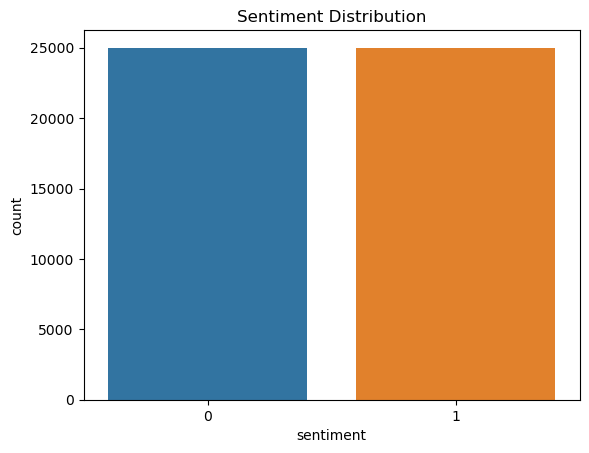

In [7]:
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

2. Review Length Distribution

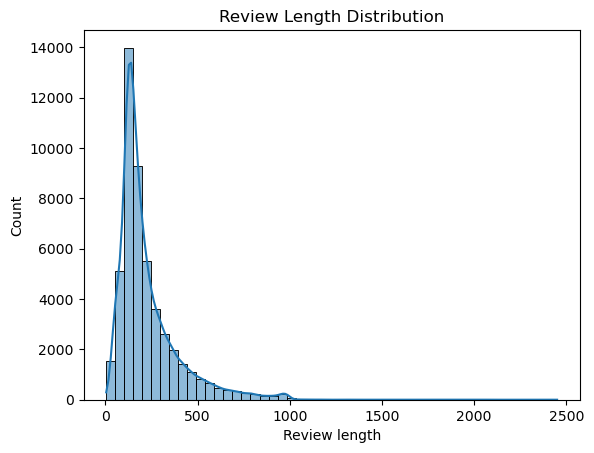

In [8]:
df['Review length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['Review length'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.show()

### Train-Test Split (60:40)

In [9]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['review'], df['sentiment'], test_size=0.4, random_state=42, stratify=df['sentiment'])

print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")

Training samples: 30000, Testing samples: 20000


# Implement a Data Loader

### Dataset Class & Tokenizer

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Training Configuration

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5
KFOLD = 3

Device: cuda


# Model Training

In [12]:
kfold = KFold(n_splits=KFOLD, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_texts)):
    print(f"\n========== Fold {fold+1} / {KFOLD} ==========")
    
    X_train_fold = train_texts.iloc[train_idx]
    y_train_fold = train_labels.iloc[train_idx]
    X_val_fold = train_texts.iloc[val_idx]
    y_val_fold = train_labels.iloc[val_idx]
    
    train_dataset = IMDBDataset(X_train_fold, y_train_fold, tokenizer, MAX_LEN)
    val_dataset = IMDBDataset(X_val_fold, y_val_fold, tokenizer, MAX_LEN)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model = model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LR)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{EPOCHS}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        acc = accuracy_score(val_labels, val_preds)
        print(f"Fold {fold+1} | Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {acc:.4f}")



========== Fold 1 / 3 ==========


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/bert-base-uncased/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:   2%|2         | 10.5M/440M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/bert-base-uncased/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:  24%|##3       | 105M/440M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/bert-base-uncased/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...
'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 388ece6d-597b-4acf-a6e0-2118a100f39e)')' thrown while requesting GET https://huggingface.co/bert-base-uncased/resolve/main/model.safetensors
Retrying in 1s [Retry 1/5].


model.safetensors:  24%|##3       | 105M/440M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/bert-base-uncased/resolve/main/model.safetensors: The operation did not complete (read) (_ssl.c:2576)
Trying to resume download...
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b468398d-acf1-47bc-948c-a8ab72df7a3b)')' thrown while requesting GET https://huggingface.co/bert-base-uncased/resolve/main/model.safetensors
Retrying in 1s [Retry 1/5].


model.safetensors:  26%|##6       | 115M/440M [00:00<?, ?B/s]

c:\Users\hp\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initi

Fold 1 | Epoch 1 | Train Loss: 0.3441 | Val Accuracy: 0.8838


Fold 1 | Epoch 2/3: 100%|██████████| 1250/1250 [14:12<00:00,  1.47it/s]


Fold 1 | Epoch 2 | Train Loss: 0.2004 | Val Accuracy: 0.8906


Fold 1 | Epoch 3/3: 100%|██████████| 1250/1250 [14:13<00:00,  1.46it/s]


Fold 1 | Epoch 3 | Train Loss: 0.1185 | Val Accuracy: 0.8900

========== Fold 2 / 3 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold 2 | Epoch 1/3: 100%|██████████| 1250/1250 [14:14<00:00,  1.46it/s]


Fold 2 | Epoch 1 | Train Loss: 0.3367 | Val Accuracy: 0.8837


Fold 2 | Epoch 2/3: 100%|██████████| 1250/1250 [14:14<00:00,  1.46it/s]


Fold 2 | Epoch 2 | Train Loss: 0.1935 | Val Accuracy: 0.8876


Fold 2 | Epoch 3/3: 100%|██████████| 1250/1250 [14:13<00:00,  1.46it/s]


Fold 2 | Epoch 3 | Train Loss: 0.1120 | Val Accuracy: 0.8908

========== Fold 3 / 3 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold 3 | Epoch 1/3: 100%|██████████| 1250/1250 [14:13<00:00,  1.46it/s]


Fold 3 | Epoch 1 | Train Loss: 0.3360 | Val Accuracy: 0.8946


Fold 3 | Epoch 2/3: 100%|██████████| 1250/1250 [14:13<00:00,  1.46it/s]


Fold 3 | Epoch 2 | Train Loss: 0.1949 | Val Accuracy: 0.8944


Fold 3 | Epoch 3/3: 100%|██████████| 1250/1250 [14:13<00:00,  1.46it/s]


Fold 3 | Epoch 3 | Train Loss: 0.1127 | Val Accuracy: 0.8944


# Test and Evaluate the Model

### Predicting values on test data

In [13]:
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
test_preds, test_true, test_probs = [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1] 
        preds = torch.argmax(outputs.logits, dim=1)
        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

Testing: 100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s]


### Evaluation Matrics

In [14]:
test_acc = accuracy_score(test_true, test_preds)
print("\nFinal Test Accuracy:", round(test_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(test_true, test_preds))


Final Test Accuracy: 89.56 %

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89     10000
           1       0.89      0.91      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



### Confusion Matrics

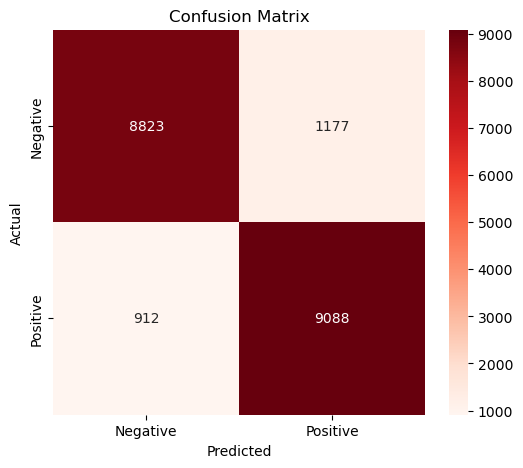

In [15]:
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### ROC Curve

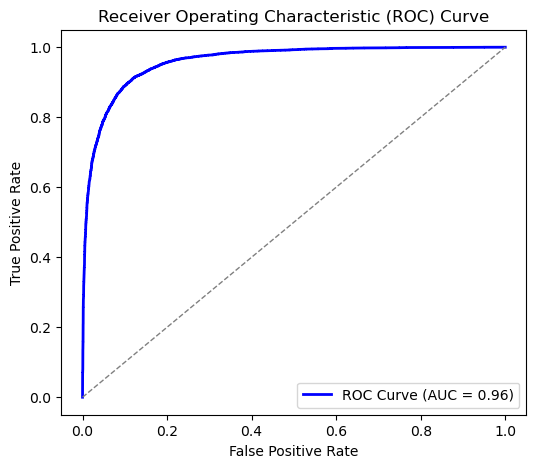

In [16]:
fpr, tpr, thresholds = roc_curve(test_true, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Create and Save Test Report

In [17]:
import datetime
from sklearn.metrics import precision_score, recall_score, f1_score


1. Required Matrices
2. Timestamp

In [19]:
precision = precision_score(test_true, test_preds)
recall = recall_score(test_true, test_preds)
f1 = f1_score(test_true, test_preds)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


### Report

In [24]:
report_text = f"""
==================================================================
Transformers for Movie Review Sentiment Analysis Evaluation Report
==================================================================

Report Generated: {timestamp}

Dataset Summary:
------------------------------------------------------------------
Total samples: {len(df)}
Training samples: {len(train_texts)}
Testing samples: {len(test_texts)}
K-Folds: {KFOLD}
Epochs per fold: {EPOCHS}
Batch size: {BATCH_SIZE}
Max Token Length: {MAX_LEN}

Model Configuration:
------------------------------------------------------------------
Model: BERT-base-uncased
Optimizer: AdamW
Learning Rate: {LR}
Scheduler: Linear Warmup
Loss Function: CrossEntropyLoss
Device Used: {device}

Final Test Performance:
------------------------------------------------------------------
Test Accuracy  : {test_acc:.4f}
Precision       : {precision:.4f}
Recall          : {recall:.4f}
F1-Score        : {f1:.4f}
ROC-AUC         : {roc_auc:.4f}

Confusion Matrix:
------------------------------------------------------------------
TN = {cm[0][0]}   FP = {cm[0][1]}
FN = {cm[1][0]}   TP = {cm[1][1]}

Classification Report:
------------------------------------------------------------------
{classification_report(test_true, test_preds)}

==================================================================
End of Report
==================================================================
"""

# Save to file
with open("Transformers for Movie Review Sentiment Analysis Evaluation Report.txt", "w", encoding="utf-8") as f:
    f.write(report_text)

print("\nTest report has been generated and saved as 'Transformers for Movie Review Sentiment Analysis Evaluation Report.txt'")


Test report has been generated and saved as 'Transformers for Movie Review Sentiment Analysis Evaluation Report.txt'
